In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency, metrics

import helper
sys.path.append('../..')
import mutagenesisfunctions as mf
np.random.seed(247)
tf.set_random_seed(247)

In [2]:
data_path = '../data/Synthetic_dataset.h5'
results_path = '../results'
params_path = utils.make_directory(results_path, 'model_params')
plot_path = utils.make_directory(results_path, 'FoM_layers')

# load dataset
train, valid, test = helper.load_synthetic_dataset(data_path)

test_model = helper.load_synthetic_models(data_path, dataset='test')
    
# get data shapes
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = [None, train['targets'].shape[1]]

loading training data
loading cross-validation data
loading test data


In [7]:
tf.reset_default_graph()

model_name = 'LocalNet'
plot_path = utils.make_directory(plot_path, model_name)
dropout_status = True
l2_status = True
bn_status = True
    
# load model parameters
model_layers, optimization, genome_model = helper.load_model(model_name, 
                                                             input_shape, 
                                                             dropout_status, 
                                                             l2_status, 
                                                             bn_status)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization, supervised=True)

# compile neural trainers
model_path = utils.make_directory(params_path, model_name)
file_path = os.path.join(model_path, model_name+'_do_l2_bn')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=file_path)

# initialize session
sess = utils.initialize_session()

# load best parameters
nntrainer.set_best_parameters(sess)

activations = nntrainer.get_activations(sess, test, layer='output')

making directory: ../results/FoM_layers/ShallowNet/LocalNet/LocalNet/LocalNet/LocalNet
loading model from:  ../results/model_params/LocalNet/LocalNet_do_l2_bn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/model_params/LocalNet/LocalNet_do_l2_bn_best.ckpt


In [8]:
nnmodel.inspect_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 200, 1, 4)
layer2: conv1d_0
(?, 200, 1, 24)
layer3: conv1d_0_batch
(?, 200, 1, 24)
layer4: conv1d_0_active
(?, 200, 1, 24)
layer5: conv1d_0_maxpool
(?, 4, 1, 24)
layer6: conv1d_0_dropout
(?, 4, 1, 24)
layer7: conv1d_1
(?, 1, 1, 96)
layer8: conv1d_1_batch
(?, 1, 1, 96)
layer9: conv1d_1_active
(?, 1, 1, 96)
layer10: conv1d_1_dropout
(?, 1, 1, 96)
layer11: dense_0
(?, 1)
layer12: dense_0_bias
(?, 1)
layer13: output
(?, 1)
----------------------------------------------------------------------------


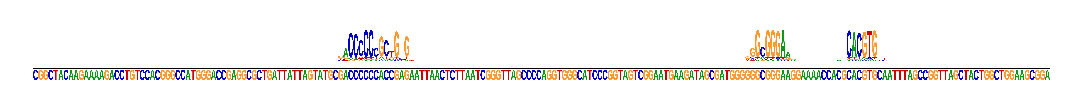

In [10]:

target = 0.9865 # 9865  9815

right_index = np.where(test['targets'][:,0]==1)[0]
index = right_index[np.argmin((activations[right_index] - target)**2)]

X = np.expand_dims(test['inputs'][index], axis=0)
X_model = test_model[index]


fig = plt.figure(figsize=(15,7))

visualize.plot_seq_pos_saliency(np.squeeze(X).T, X_model, alphabet='dna', nt_width=50, norm_factor=3)


output_name = 'modelsequence_' + str(index)
outfile = os.path.join(plot_path, output_name+'.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

# 1st Layer

In [18]:
def fom_convsal(X, layer, alphabet, filter_index, max_idx, nntrainer, sess, normalize=False,
                title='notitle', figsize=(15,2), fig=None, pos=None, idx=None):
    
    eps = 1e-7
    
    #first mutate the sequence
    X_mut = mf.mutate(X, X.shape[1], X.shape[3])

    #take all the mutations and assign them into a dict for deepomics
    mutations = {'inputs': X_mut, 'targets': np.ones((X_mut.shape[0], 1))}
    #Get the neurons score for the mutations
    mut_scores = nntrainer.get_activations(sess, mutations, layer=layer)[:, max_idx[filter_index], :, filter_index]

    #take the WT and put it into a dict for deepomics
    WT = {'inputs': X, 'targets': np.ones((X.shape[0], 1))}
    #Get activations for the WT sequence
    WT_score = nntrainer.get_activations(sess, WT, layer=layer)[:, max_idx[filter_index], :, filter_index]

    #shape the predictions of the mutations into the shape of a heatmap
    heat_mut = mut_scores.reshape(X.shape[1],4).T
    
    if normalize:
        #normalize the heat map rearrangement by minusing it by the true prediction score of that test sequence
        norm_heat_mut = (heat_mut - WT_score) + eps
        norm_heat_mut = utils.normalize_pwm(norm_heat_mut, factor=4)

        return (norm_heat_mut)
    
    if not normalize:
        return (heat_mut)

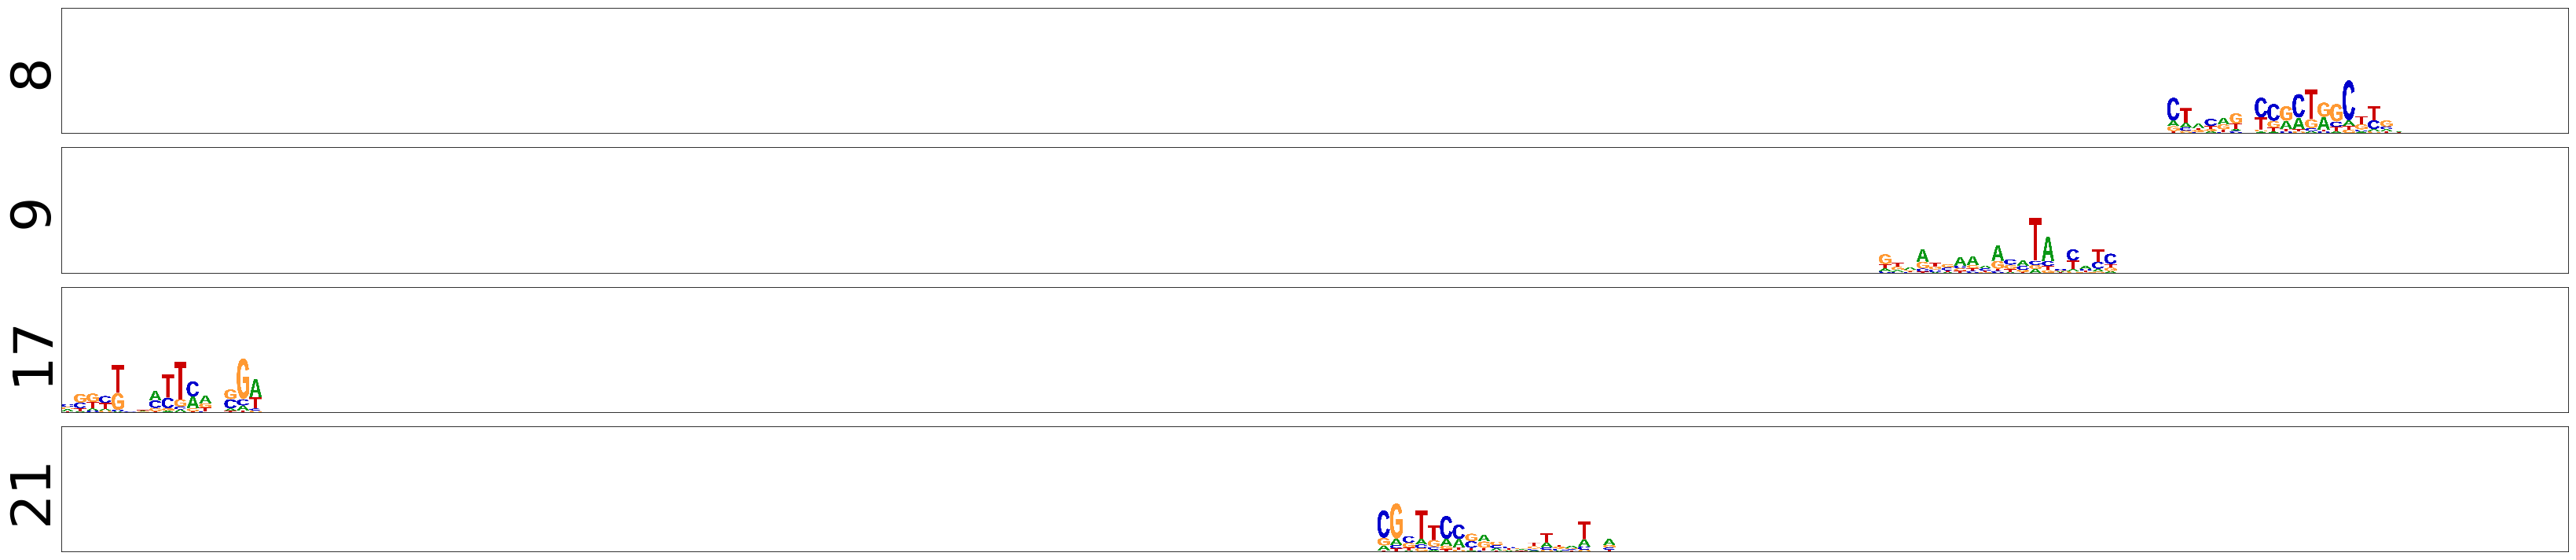

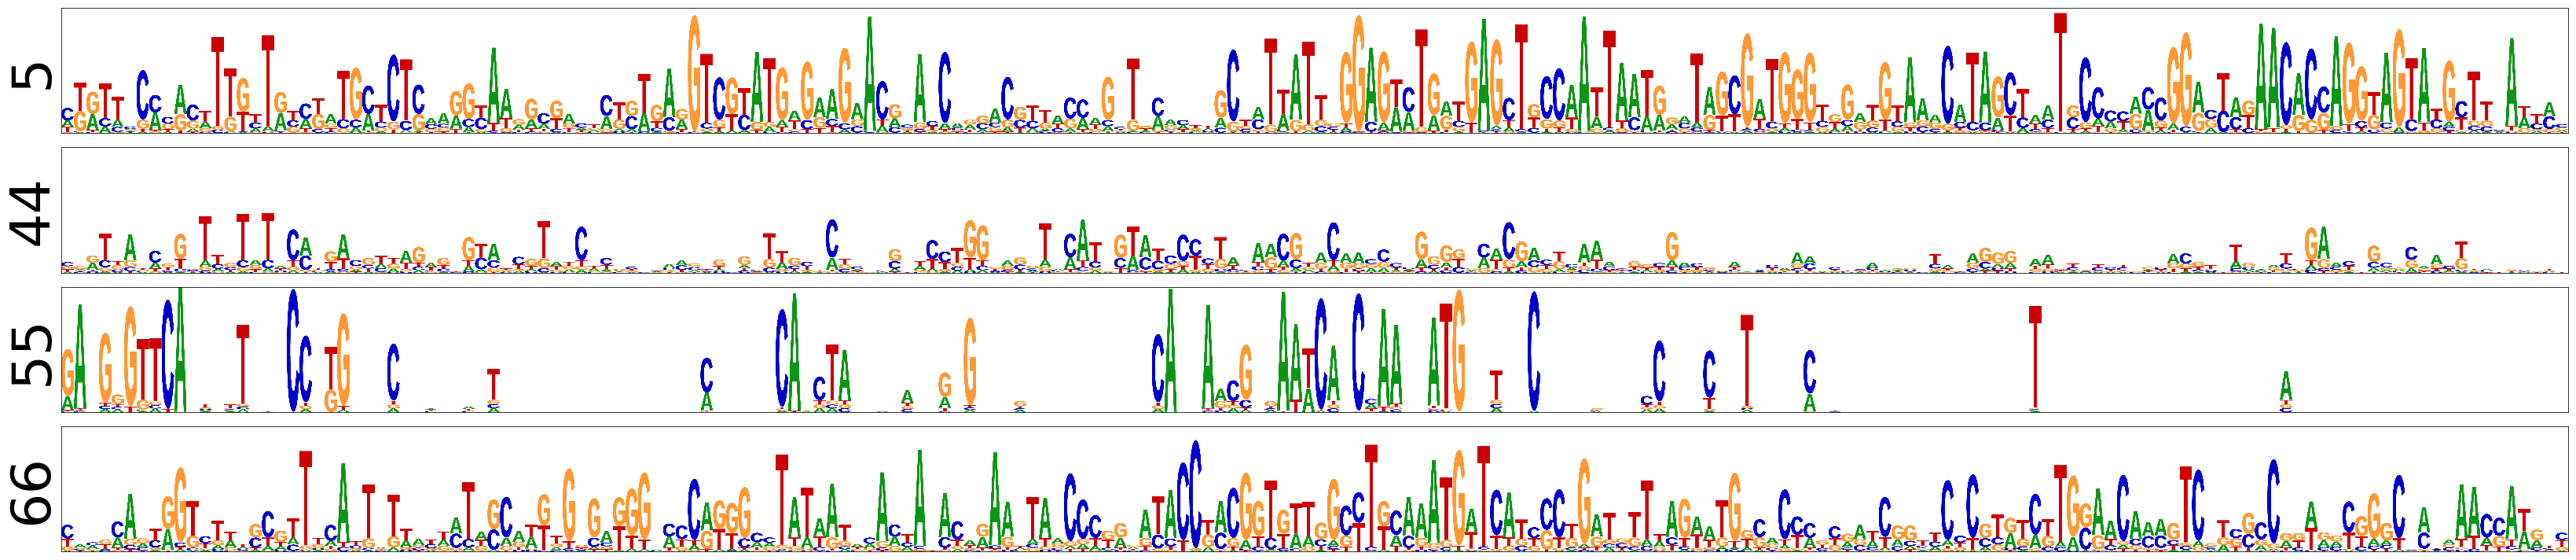

In [19]:
neuron_plot = [['conv1d_0_active', [8,9,17,21]], 
                 ['conv1d_1_active', [5,44,55,66]]] 

for layer, active_indices in neuron_plot:

    layer_dict = {'inputs': X, 'targets': np.ones((X.shape[0], 1))}
    layer_act = nntrainer.get_activations(sess, layer_dict, layer=layer)

    #For each filter what is the index of the maximally activated neuron
    max_idx = np.squeeze(np.argmax(layer_act, axis=1))

    #Identify the desired filter
    filters = active_indices
    
    normalize = False
    fom_scores = []
    for filter_index in filters:
    #Get the FoM scores for each desired filter
        fom_scores.append(fom_convsal(X, layer, 'dna', filter_index, max_idx, nntrainer, sess, normalize=normalize))

    num_plots = len(filters)
    
    if normalize:
        factor = 3
    if not normalize:
        factor = 12
    
    fig = plt.figure(figsize=(100,10))
    plt.title(str(layer), fontsize=70)
    plt.subplot(num_plots,1,1)
    pwm = utils.normalize_pwm(fom_scores[0], factor=factor)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[0]), fontsize=70)

    plt.subplot(num_plots,1,2)
    pwm = utils.normalize_pwm(fom_scores[1], factor=factor)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[1]), fontsize=70)

    plt.subplot(num_plots,1,3)
    pwm = utils.normalize_pwm(fom_scores[2], factor=factor)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[2]), fontsize=70)

    plt.subplot(num_plots,1,4)
    pwm = utils.normalize_pwm(fom_scores[3], factor=factor)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[3]), fontsize=70)

INFO:tensorflow:Restoring parameters from ../results/model_params/LocalNet/LocalNet_do_l2_bn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/model_params/LocalNet/LocalNet_do_l2_bn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/model_params/LocalNet/LocalNet_do_l2_bn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/model_params/LocalNet/LocalNet_do_l2_bn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/model_params/LocalNet/LocalNet_do_l2_bn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/model_params/LocalNet/LocalNet_do_l2_bn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/model_params/LocalNet/LocalNet_do_l2_bn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/model_params/LocalNet/LocalNet_do_l2_bn_best.ckpt


deepomics/utils.py:112: RuntimeWarning: invalid value encountered in divide
  pwm = pwm/max


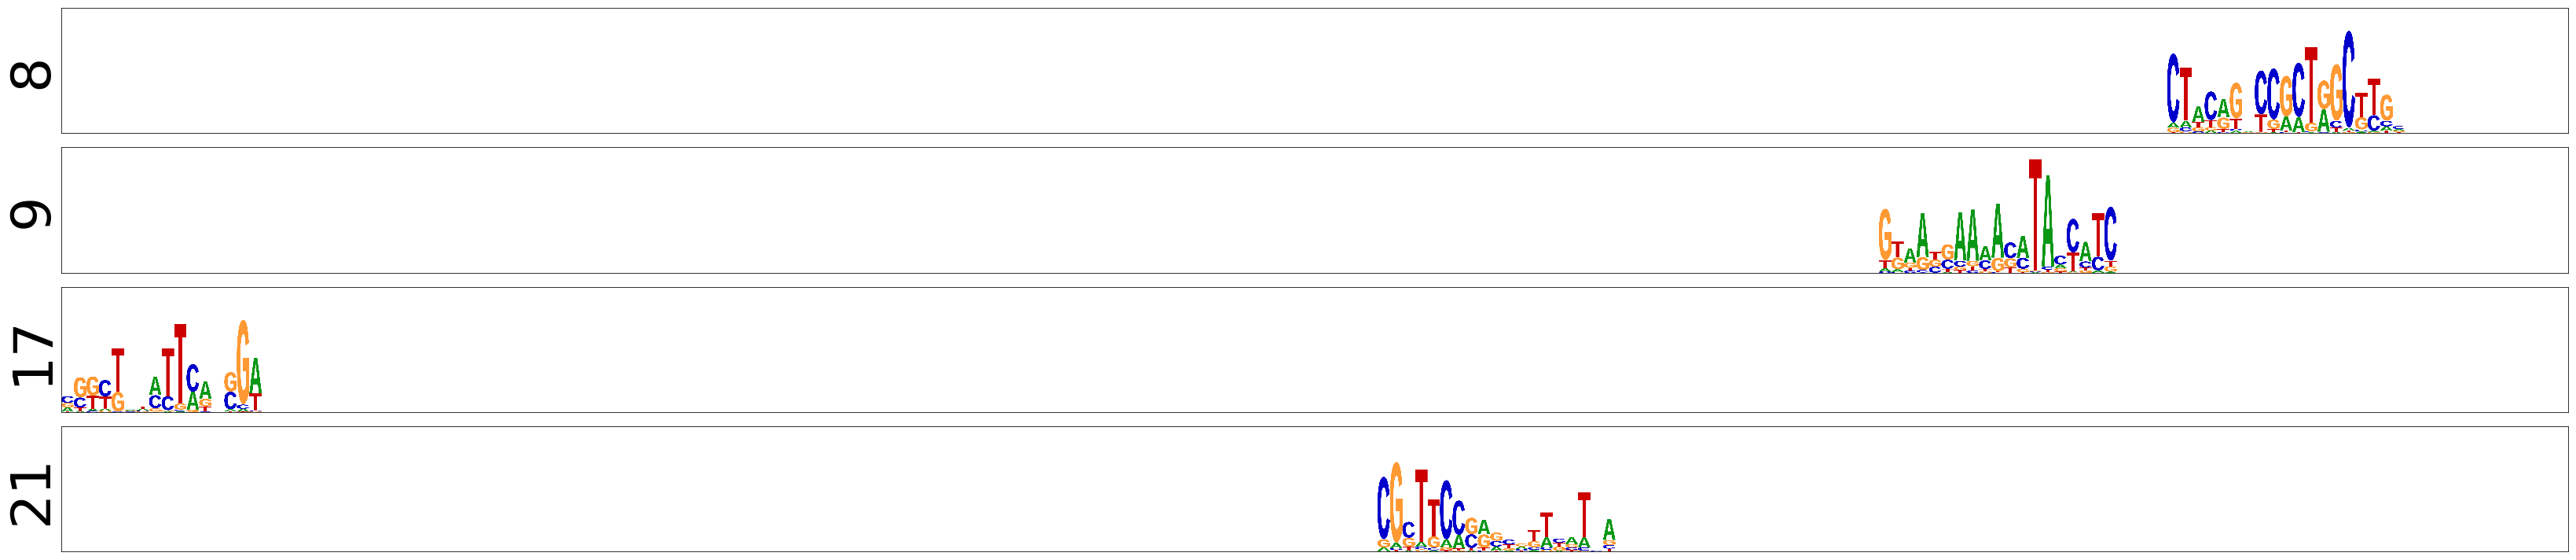

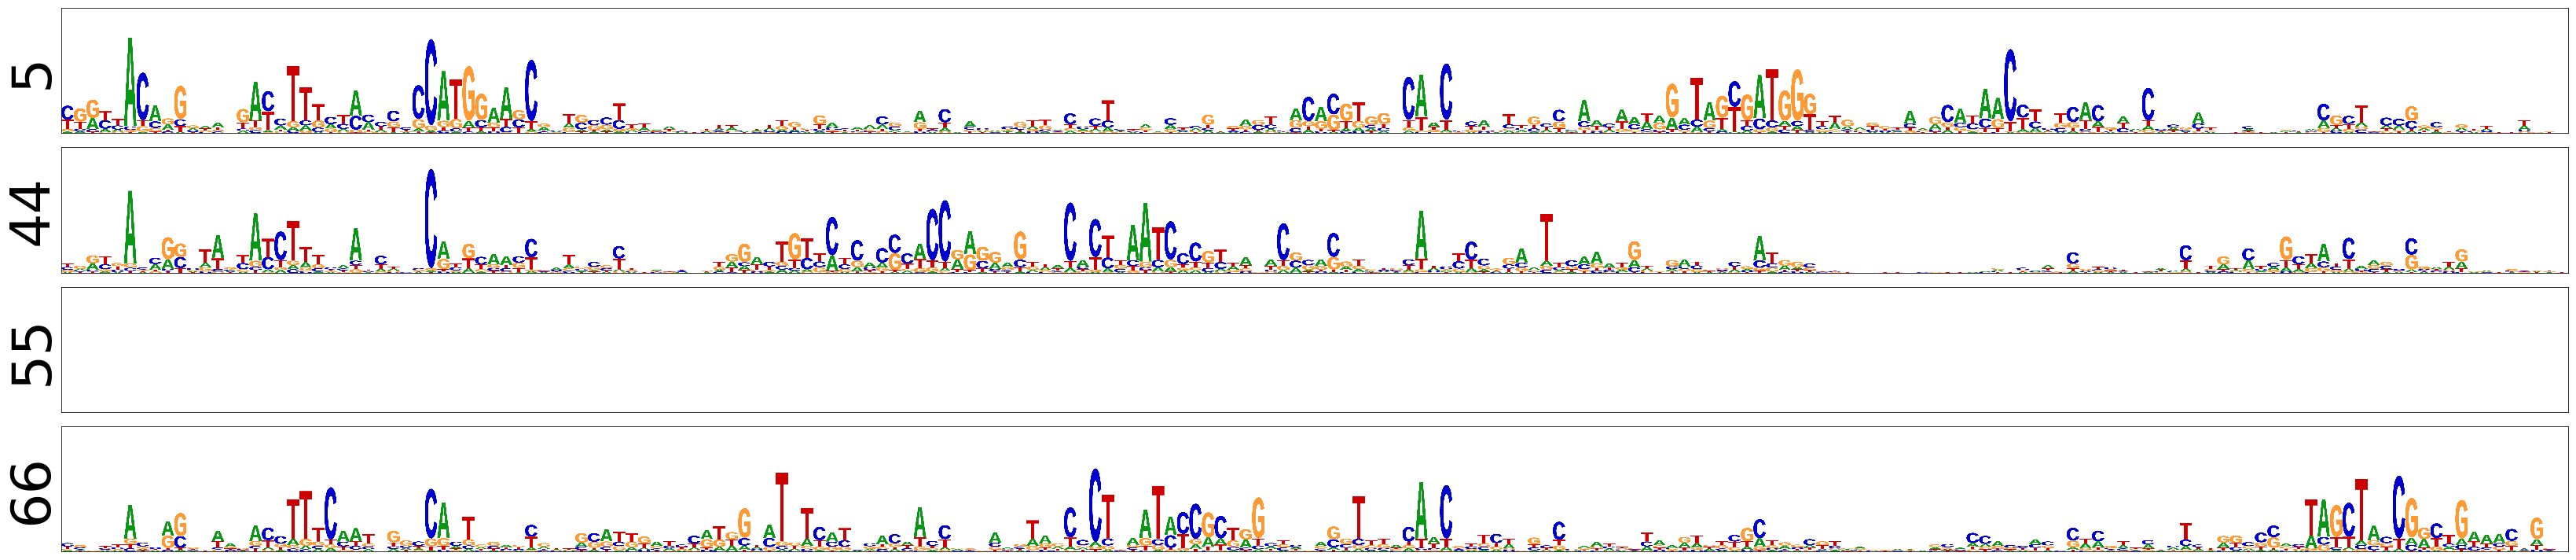

In [14]:
for layer, active_indices in neuron_plot:

        # saliency parameters
    params = {'model_name': model_name, 
              'input_shape': input_shape, 
              'dropout_status': dropout_status,
              'l2_status': l2_status,
              'bn_status': bn_status,
              'model_path': file_path+'_best.ckpt',
             }


    num_plots = len(active_indices)

    saliency = []
    for neuron_index in active_indices:
        val = helper.backprop(X, layer=layer, class_index=neuron_index, params=params, method='guided')
        saliency.append(val)



    fig = plt.figure(figsize=(100,10))
    plt.title(str(layer), fontsize=70)
    plt.subplot(num_plots,1,1)
    pwm = utils.normalize_pwm(np.squeeze(saliency[0]).T, factor=3)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(active_indices[0]), fontsize=70)

    plt.subplot(num_plots,1,2)
    pwm = utils.normalize_pwm(np.squeeze(saliency[1]).T, factor=3)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(active_indices[1]), fontsize=70)

    plt.subplot(num_plots,1,3)
    pwm = utils.normalize_pwm(np.squeeze(saliency[2]).T, factor=3)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(active_indices[2]), fontsize=70)

    plt.subplot(num_plots,1,4)
    pwm = utils.normalize_pwm(np.squeeze(saliency[3]).T, factor=3)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(active_indices[3]), fontsize=70)

    #save_path = utils.make_directory(results_path, 'layers')
    #outfile = os.path.join(save_path,model_name+'_layer1.pdf')
    #fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')






